### Suggestions from Tutor
* Perhaps with SPY or other indices
* perform an hourly training/5 min traning, etc. 
* store pre-trained model 
* current data for prediction
* load model
* get ticker name input
* predict usining model
* show results

### Initial ML Attempt using LSTM RNN

_**Binary Keras LSTM model does not output binary predictions**_

"There is no 'binary' in neural networks, but a continuous function within limits.
Only with continuous functions a model can train and learn using "stochastic gradient descent".
For trying to achieve binary results, we use the sigmoid function, which goes from 0 to 1. But initially, your model is not trained, all its "weights" are sort of initialised randomly. 
The result is indeed results tending to mean values, which are 0.5 in sigmoid functions.
All you need is to train your model with enough data for enough epochs, 
so the results will gradually approach (but never hit) 0 or 1 (or whatever targets "y" you have in your training data)"

Source: https://stackoverflow.com/questions/46040656/binary-keras-lstm-model-does-not-output-binary-predictions

In [181]:
#Source: https://github.com/Derrick-Sherrill/DerrickSherrill.com/blob/master/stocks.py

import os
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time
from path import Path
%matplotlib inline
from datetime import datetime as dt
from dateutil.tz import gettz
import re
import numpy as np
import pandas as pd
import hvplot.pandas
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
import keras
from newsapi import NewsApiClient

#!pip install alpha_vantage
# get API from alpha vantage
api_key_stocks = os.getenv("ALPHA_VANTAGE_API_KEY")

#import nltk
#nltk.download()
from nltk.corpus import reuters
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Read your api key environment variable
api_key_news = os.getenv("NEWS_API_KEY")
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key_news)


In [182]:
tickers = ['SPY','DJIA','AAPL', 'GOOG', 'FB', 'NFLX','DIS', 'MSFT', 'IBM']

# News Data

In [183]:
# Fetch the news articles for the chosen ticker
ticker = input ("Enter ticker :") 

news_headlines = newsapi.get_everything(
    q=ticker, language="en", sort_by="relevancy"
)



# Print total articles
print(f"Total articles about {ticker}: {news_headlines['totalResults']}")
# Show sample article
news_headlines["articles"][0]

Enter ticker : AAPL


Total articles about AAPL: 805


{'source': {'id': 'business-insider', 'name': 'Business Insider'},
 'author': 'Lisa Eadicicco',
 'title': 'Apple is donating 9 million protective face masks to help fight the coronavirus pandemic (AAPL)',
 'description': 'Apple is donating 9 million protective face masks to COVID-19 relief efforts in the US, the Vice President Mike Pence said in a press briefing on Tuesday. The vice president said he and President Trump recently spoke with Apple CEO Tim Cook. Cook is one of se…',
 'url': 'https://www.businessinsider.com/apple-tim-cook-donate-9-million-n95-face-masks-coronavirus-2020-3',
 'urlToImage': 'https://i.insider.com/5e7a965f0c2a6275d6005217?width=1200&format=jpeg',
 'publishedAt': '2020-03-24T23:33:01Z',
 'content': 'Apple is donating 9 million protective face masks to help combat the ongoing coronavirus pandemic, Vice President Mike Pence said during a press briefing on Tuesday.\r\n"And I spoke today, and the president spoke last week, with Tim Cook of Apple," Pence said. … [+

In [184]:
news_df = pd.DataFrame.from_dict(news_headlines['articles'])
news_df.head()

,source,author,title,description,url,urlToImage,publishedAt,content
0,"{'id': 'business-insider', 'name': 'Business I...",Lisa Eadicicco,Apple is donating 9 million protective face ma...,Apple is donating 9 million protective face ma...,https://www.businessinsider.com/apple-tim-cook...,https://i.insider.com/5e7a965f0c2a6275d6005217...,2020-03-24T23:33:01Z,Apple is donating 9 million protective face ma...
1,"{'id': 'business-insider', 'name': 'Business I...",Lisa Eadicicco,Apple's retail stores are closed until further...,Apple's retail stores are currently closed unt...,https://www.businessinsider.com/apple-stores-c...,https://i.insider.com/5e70f2dcc485403371351254...,2020-03-17T15:57:16Z,Apple's retail stores are currently closed unt...
2,"{'id': 'business-insider', 'name': 'Business I...",Lisa Eadicicco,Apple's next major iPhone update could complet...,Apple is reportedly working on a new feature t...,https://www.businessinsider.com/apple-ios-14-r...,https://i.insider.com/5e8f93f98427e96ead4d9cf5...,2020-04-09T21:43:30Z,Apple's next major iPhone update could include...
3,"{'id': 'business-insider', 'name': 'Business I...",Mary Meisenzahl,Adding wheels to your Mac Pro will cost as muc...,Apple is selling wheels and a kit to attach th...,https://www.businessinsider.com/apple-mac-pro-...,https://i.insider.com/5e974fa0c023207028070e8c...,2020-04-15T18:42:08Z,Apple's priciest computer now has another expe...
4,"{'id': None, 'name': '9to5mac.com'}",Chance Miller,Analyst predicts year-end rebound for AAPL as ...,AAPL stock fell more than 12% at the market op...,https://9to5mac.com/2020/03/17/aapl-stock-jump...,https://9to5mac.com/wp-content/uploads/sites/6...,2020-03-17T21:41:23Z,AAPL stock fell more than 12% at the market op...


In [185]:
# Create the ticker sentiment scores DataFrame
sentiments = []

for article in news_headlines["articles"]:
    try:
        
        text = article["content"]
        date = article["publishedAt"]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        neg = sentiment["neg"]
        neu = sentiment["neu"]
        pos = sentiment["pos"]
        
        sentiments.append({
            "date": date,
            "Compound": compound,
            "Negative": neg,
            "Neutral": neu,
            "Positive": pos,
            "Text": text,
 
        })
        
    except AttributeError:
        pass
    
# Create DataFrame
sentiments_df = pd.DataFrame(sentiments)

# Reorder DataFrame columns
cols = ["date", "Compound", "Negative", "Neutral", "Positive", "Text"]
sentiments_df = sentiments_df[cols]

sentiments_df.tail()

,date,Compound,Negative,Neutral,Positive,Text
14,2020-03-16T11:00:00Z,-0.1027,0.033,0.967,0.000,Business Insider\r\nAs the coronavirus outbrea...
15,2020-04-09T18:55:31Z,-0.1779,0.056,0.903,0.041,"If you're an iPhone owner, you've probably rec..."
16,2020-04-02T16:13:46Z,0.6597,0.000,0.878,0.122,Apple is teaming up with philanthropist Lauren...
17,2020-03-27T16:56:58Z,0.0000,0.000,1.000,0.000,Apple released a new COVID-19 screening app Fr...
18,2020-04-02T21:06:59Z,0.7579,0.000,0.845,0.155,"For months, rumors have been swirling that App..."


In [186]:
sentiments_df['date'] = pd.to_datetime(sentiments_df['date'], infer_datetime_format=True)
sentiments_df = sentiments_df.set_index(sentiments_df['date'])

In [187]:
sentiments = sentiments_df.drop(columns='date').sort_index()
sentiments.head()

,Compound,Negative,Neutral,Positive,Text
date,,,,,
2020-03-16 11:00:00,-0.1027,0.033,0.967,0.000,Business Insider\r\nAs the coronavirus outbrea...
2020-03-16 12:00:00,0.5859,0.000,0.888,0.112,"After an onslaught of leaks, Apple's new Power..."
2020-03-16 13:44:37,-0.5994,0.098,0.902,0.000,"With every new operating system update, there ..."
2020-03-17 15:57:16,0.3612,0.000,0.946,0.054,Apple's retail stores are currently closed unt...
2020-03-17 21:41:23,-0.4215,0.057,0.943,0.000,AAPL stock fell more than 12% at the market op...


In [188]:
#sentiments['Date'] = pd.to_datetime(sentiments_df['date']).dt.date
#sentiments.reset_index(inplace=True)

In [189]:
#sentiments.set_index("Date", inplace=True)

In [190]:
#sentiments.sort_index()
#sentiments.head()

In [191]:
# Describe the ticker sentiment
sentiments.describe(include='all')

,Compound,Negative,Neutral,Positive,Text
count,19.000000,19.000000,19.000000,19.000000,19
unique,NaN,NaN,NaN,NaN,19
top,NaN,NaN,NaN,NaN,"Late last year, an analyst known for his Apple..."
freq,NaN,NaN,NaN,NaN,1
mean,0.128100,0.035105,0.907158,0.057737,NaN
std,0.508849,0.055415,0.069482,0.068718,NaN
min,-0.907900,0.000000,0.776000,0.000000,NaN
25%,-0.140300,0.000000,0.864500,0.000000,NaN
50%,0.000000,0.000000,0.903000,0.041000,NaN
75%,0.622800,0.054500,0.960500,0.117000,NaN


# Stock Data

In [225]:
ticker = input ("Enter ticker :") 

ts = TimeSeries(key=api_key_stocks, output_format='pandas')
data, meta_data = ts.get_intraday(symbol=ticker, interval = '5min', outputsize = 'full')

print(ticker, data)

Enter ticker : AAPL


AAPL                       1. open   2. high    3. low  4. close  5. volume
date                                                                  
2020-04-15 16:00:00  284.1550  284.6600  284.0900  284.4500   881824.0
2020-04-15 15:55:00  284.2190  284.7200  284.0000  284.1600   462740.0
2020-04-15 15:50:00  284.5000  284.8800  284.3000  284.5202   348509.0
2020-04-15 15:45:00  284.7500  284.7898  283.9300  284.5500   442748.0
2020-04-15 15:40:00  284.7100  285.0900  284.5000  284.7400   298908.0
...                       ...       ...       ...       ...        ...
2020-03-25 09:55:00  252.7594  253.4800  249.8700  250.5900  1302618.0
2020-03-25 09:50:00  254.7000  254.8300  252.5801  252.7200  1069478.0
2020-03-25 09:45:00  257.8700  258.2500  254.3500  254.7000  1567522.0
2020-03-25 09:40:00  255.1400  257.9500  254.6000  257.8300  2031437.0
2020-03-25 09:35:00  250.7500  254.8500  250.0000  254.5420  4227634.0

[1170 rows x 5 columns]


In [227]:
close_data = data['4. close']

In [228]:
percentage_change = close_data.pct_change().fillna(0)

In [229]:
#i = 1
#while i==1:
#    data, meta_data = ts.get_intraday(symbol='DIS', interval = '1min', outputsize = 'full')
#    data.to_excel("output.xlsx")
#    time.sleep(60)

print(percentage_change)

date
2020-04-15 16:00:00    0.000000
2020-04-15 15:55:00   -0.001020
2020-04-15 15:50:00    0.001268
2020-04-15 15:45:00    0.000105
2020-04-15 15:40:00    0.000668
                         ...   
2020-03-25 09:55:00   -0.001156
2020-03-25 09:50:00    0.008500
2020-03-25 09:45:00    0.007835
2020-03-25 09:40:00    0.012289
2020-03-25 09:35:00   -0.012753
Name: 4. close, Length: 1170, dtype: float64


In [230]:
last_change = percentage_change[-1]
if abs(last_change) > 0.0004:
    print(f"{ticker} Alert: " + str(last_change))

AAPL Alert: -0.01275258891517661


In [231]:
quotes = data.sort_index()
quotes['6. change'] = percentage_change

In [232]:
quotes

,1. open,2. high,3. low,4. close,5. volume,6. change
date,,,,,,
2020-03-25 09:35:00,250.7500,254.8500,250.0000,254.5420,4227634.0,-0.012753
2020-03-25 09:40:00,255.1400,257.9500,254.6000,257.8300,2031437.0,0.012289
2020-03-25 09:45:00,257.8700,258.2500,254.3500,254.7000,1567522.0,0.007835
2020-03-25 09:50:00,254.7000,254.8300,252.5801,252.7200,1069478.0,0.008500
2020-03-25 09:55:00,252.7594,253.4800,249.8700,250.5900,1302618.0,-0.001156
...,...,...,...,...,...,...
2020-04-15 15:40:00,284.7100,285.0900,284.5000,284.7400,298908.0,0.000668
2020-04-15 15:45:00,284.7500,284.7898,283.9300,284.5500,442748.0,0.000105
2020-04-15 15:50:00,284.5000,284.8800,284.3000,284.5202,348509.0,0.001268


In [233]:
quotes['7. increase'] = (quotes['6. change'] > 0).astype(int)
quotes

,1. open,2. high,3. low,4. close,5. volume,6. change,7. increase
date,,,,,,,
2020-03-25 09:35:00,250.7500,254.8500,250.0000,254.5420,4227634.0,-0.012753,0
2020-03-25 09:40:00,255.1400,257.9500,254.6000,257.8300,2031437.0,0.012289,1
2020-03-25 09:45:00,257.8700,258.2500,254.3500,254.7000,1567522.0,0.007835,1
2020-03-25 09:50:00,254.7000,254.8300,252.5801,252.7200,1069478.0,0.008500,1
2020-03-25 09:55:00,252.7594,253.4800,249.8700,250.5900,1302618.0,-0.001156,0
...,...,...,...,...,...,...,...
2020-04-15 15:40:00,284.7100,285.0900,284.5000,284.7400,298908.0,0.000668,1
2020-04-15 15:45:00,284.7500,284.7898,283.9300,284.5500,442748.0,0.000105,1
2020-04-15 15:50:00,284.5000,284.8800,284.3000,284.5202,348509.0,0.001268,1


In [234]:
#quotes.reset_index(inplace=True)
#quotes['Date'] = quotes['date'].dt.date
#quotes.set_index('Date', inplace=True)

In [235]:
#quotes.sort_index()
#quotes.head()

# Join the Dataframes

In [236]:
df_outjoin = pd.concat([sentiments, quotes], axis=1, join='outer')
df_outjoin.reset_index(inplace=True)
df_outjoin['Date'] = df_outjoin['date'].dt.date
df_outjoin['Hour'] = df_outjoin['date'].dt.hour
df_outjoin

,date,Compound,Negative,Neutral,Positive,Text,1. open,2. high,3. low,4. close,5. volume,6. change,7. increase,Date,Hour
0,2020-03-16 11:00:00,-0.1027,0.033,0.967,0.000,Business Insider\r\nAs the coronavirus outbrea...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-16,11
1,2020-03-16 12:00:00,0.5859,0.000,0.888,0.112,"After an onslaught of leaks, Apple's new Power...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-16,12
2,2020-03-16 13:44:37,-0.5994,0.098,0.902,0.000,"With every new operating system update, there ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-16,13
3,2020-03-17 15:57:16,0.3612,0.000,0.946,0.054,Apple's retail stores are currently closed unt...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-17,15
4,2020-03-17 21:41:23,-0.4215,0.057,0.943,0.000,AAPL stock fell more than 12% at the market op...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-17,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1184,2020-04-15 15:45:00,NaN,NaN,NaN,NaN,NaN,284.750,284.7898,283.93,284.5500,442748.0,0.000105,1.0,2020-04-15,15
1185,2020-04-15 15:50:00,NaN,NaN,NaN,NaN,NaN,284.500,284.8800,284.30,284.5202,348509.0,0.001268,1.0,2020-04-15,15
1186,2020-04-15 15:55:00,NaN,NaN,NaN,NaN,NaN,284.219,284.7200,284.00,284.1600,462740.0,-0.001020,0.0,2020-04-15,15
1187,2020-04-15 16:00:00,NaN,NaN,NaN,NaN,NaN,284.155,284.6600,284.09,284.4500,881824.0,0.000000,0.0,2020-04-15,16


In [237]:
df_outjoin = df_outjoin.drop(columns=['Text', '1. open', '2. high', '3. low', '4. close', '5. volume', '6. change'])
df_outjoin

,date,Compound,Negative,Neutral,Positive,7. increase,Date,Hour
0,2020-03-16 11:00:00,-0.1027,0.033,0.967,0.000,NaN,2020-03-16,11
1,2020-03-16 12:00:00,0.5859,0.000,0.888,0.112,NaN,2020-03-16,12
2,2020-03-16 13:44:37,-0.5994,0.098,0.902,0.000,NaN,2020-03-16,13
3,2020-03-17 15:57:16,0.3612,0.000,0.946,0.054,NaN,2020-03-17,15
4,2020-03-17 21:41:23,-0.4215,0.057,0.943,0.000,NaN,2020-03-17,21
...,...,...,...,...,...,...,...,...
1184,2020-04-15 15:45:00,NaN,NaN,NaN,NaN,1.0,2020-04-15,15
1185,2020-04-15 15:50:00,NaN,NaN,NaN,NaN,1.0,2020-04-15,15
1186,2020-04-15 15:55:00,NaN,NaN,NaN,NaN,0.0,2020-04-15,15
1187,2020-04-15 16:00:00,NaN,NaN,NaN,NaN,0.0,2020-04-15,16


In [238]:
#df = df_outjoin.fillna(0)
df = df_outjoin.drop(columns=['Date', 'Hour'])

In [239]:
df.rename(columns={'date': 'Date', '7. increase': 'Increase'}, inplace=True)

In [240]:
df = df.set_index('Date')
df = df.fillna(0)
df

,Compound,Negative,Neutral,Positive,Increase
Date,,,,,
2020-03-16 11:00:00,-0.1027,0.033,0.967,0.000,0.0
2020-03-16 12:00:00,0.5859,0.000,0.888,0.112,0.0
2020-03-16 13:44:37,-0.5994,0.098,0.902,0.000,0.0
2020-03-17 15:57:16,0.3612,0.000,0.946,0.054,0.0
2020-03-17 21:41:23,-0.4215,0.057,0.943,0.000,0.0
...,...,...,...,...,...
2020-04-15 15:45:00,0.0000,0.000,0.000,0.000,1.0
2020-04-15 15:50:00,0.0000,0.000,0.000,0.000,1.0
2020-04-15 15:55:00,0.0000,0.000,0.000,0.000,0.0


In [241]:
df.Increase = df.Increase.astype('str')
df = pd.get_dummies(df, drop_first=True)

In [242]:
df

,Compound,Negative,Neutral,Positive,Increase_1.0
Date,,,,,
2020-03-16 11:00:00,-0.1027,0.033,0.967,0.000,0
2020-03-16 12:00:00,0.5859,0.000,0.888,0.112,0
2020-03-16 13:44:37,-0.5994,0.098,0.902,0.000,0
2020-03-17 15:57:16,0.3612,0.000,0.946,0.054,0
2020-03-17 21:41:23,-0.4215,0.057,0.943,0.000,0
...,...,...,...,...,...
2020-04-15 15:45:00,0.0000,0.000,0.000,0.000,1
2020-04-15 15:50:00,0.0000,0.000,0.000,0.000,1
2020-04-15 15:55:00,0.0000,0.000,0.000,0.000,0


In [223]:
df.describe(include='all')

,Compound,Negative,Neutral,Positive,Increase_1.0
count,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000
mean,0.002047,0.000561,0.014496,0.000923,0.473507
std,0.064664,0.008119,0.114124,0.011136,0.499508
min,-0.907900,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.836000,0.224000,1.000000,0.191000,1.000000


In [243]:
df.rename(columns={'Increase_1.0': 'Increase'}, inplace=True)
df.head()

,Compound,Negative,Neutral,Positive,Increase
Date,,,,,
2020-03-16 11:00:00,-0.1027,0.033,0.967,0.000,0
2020-03-16 12:00:00,0.5859,0.000,0.888,0.112,0
2020-03-16 13:44:37,-0.5994,0.098,0.902,0.000,0
2020-03-17 15:57:16,0.3612,0.000,0.946,0.054,0
2020-03-17 21:41:23,-0.4215,0.057,0.943,0.000,0


In [244]:
df.dtypes

Compound    float64
Negative    float64
Neutral     float64
Positive    float64
Increase      uint8
dtype: object

In [248]:
df.to_pickle('../Data/aapl_min_dum.pickle')

In [249]:
# If the probability of a price increase is > 0.5, then 1; else 0.
df_hourly = df_outjoin.groupby([df_outjoin['Date'], df_outjoin['Hour']]).mean()
df_hourly['7. increase'] = (df_hourly.loc[:,'7. increase'] > 0.5).astype(int)
df_hourly.rename(columns={'7. increase': 'Increase'}, inplace=True)

In [250]:
df_hourly

Compound  Negative  Neutral  Positive  Increase
Date       Hour                                                 
2020-03-16 11     -0.1027     0.033    0.967     0.000         0
           12      0.5859     0.000    0.888     0.112         0
           13     -0.5994     0.098    0.902     0.000         0
2020-03-17 15      0.3612     0.000    0.946     0.054         0
           21     -0.4215     0.057    0.943     0.000         0
...                   ...       ...      ...       ...       ...
2020-04-15 13         NaN       NaN      NaN       NaN         0
           14         NaN       NaN      NaN       NaN         0
           15         NaN       NaN      NaN       NaN         1
           16         NaN       NaN      NaN       NaN         0
           18      0.0000     0.000    1.000     0.000         0

[134 rows x 5 columns]

In [251]:
df_hourly = df_hourly.fillna(0)
#df_hourly = pd.get_dummies(df_hourly, drop_first=True)
df_hourly.Increase = df_hourly.Increase.astype('str')
df_hourly = pd.get_dummies(df_hourly, drop_first=True)
df_hourly

Compound  Negative  Neutral  Positive  Increase_1
Date       Hour                                                   
2020-03-16 11     -0.1027     0.033    0.967     0.000           0
           12      0.5859     0.000    0.888     0.112           0
           13     -0.5994     0.098    0.902     0.000           0
2020-03-17 15      0.3612     0.000    0.946     0.054           0
           21     -0.4215     0.057    0.943     0.000           0
...                   ...       ...      ...       ...         ...
2020-04-15 13      0.0000     0.000    0.000     0.000           0
           14      0.0000     0.000    0.000     0.000           0
           15      0.0000     0.000    0.000     0.000           1
           16      0.0000     0.000    0.000     0.000           0
           18      0.0000     0.000    1.000     0.000           0

[134 rows x 5 columns]

In [252]:
df_hourly.describe(include='all')

,Compound,Negative,Neutral,Positive,Increase_1
count,134.000000,134.000000,134.000000,134.000000,134.000000
mean,0.018163,0.004978,0.128627,0.008187,0.268657
std,0.192496,0.023805,0.318663,0.032370,0.444924
min,-0.907900,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000
max,0.836000,0.224000,1.000000,0.191000,1.000000


In [262]:
df_hourly.rename(columns={'Increase_1': 'Increase'}, inplace=True)
df_hourly.head()

Compound  Negative  Neutral  Positive  Increase
Date       Hour                                                 
2020-03-16 11     -0.1027     0.033    0.967     0.000         0
           12      0.5859     0.000    0.888     0.112         0
           13     -0.5994     0.098    0.902     0.000         0
2020-03-17 15      0.3612     0.000    0.946     0.054         0
           21     -0.4215     0.057    0.943     0.000         0

In [263]:
df_hourly.dtypes

Compound    float64
Negative    float64
Neutral     float64
Positive    float64
Increase      uint8
dtype: object

In [264]:
df_hourly.to_pickle('aapl_hourly_dum.pickle')

In [265]:
# If the probability of a price increase is > 0.5, then 1; else 0.
df_daily = df_outjoin.groupby('Date').mean()
df_daily['7. increase'] = (df_daily.loc[:,'7. increase'] > 0.5).astype(int)
df_daily.rename(columns={'7. increase': 'Increase'}, inplace=True)
df_daily.drop(columns='Hour', inplace=True)
df_daily

,Compound,Negative,Neutral,Positive,Increase
Date,,,,,
2020-03-16,-0.038733,0.043667,0.9190,0.037333,0
2020-03-17,-0.030150,0.028500,0.9445,0.027000,0
2020-03-18,-0.361200,0.080000,0.9200,0.000000,0
2020-03-24,0.077200,0.053000,0.8870,0.060000,0
2020-03-25,NaN,NaN,NaN,NaN,1
2020-03-26,NaN,NaN,NaN,NaN,0
2020-03-27,0.000000,0.000000,1.0000,0.000000,0
2020-03-30,-0.907900,0.224000,0.7760,0.000000,0
2020-03-31,-0.076200,0.028000,0.9720,0.000000,1


In [266]:
df_daily = df_daily.fillna(0)
df_daily.Increase = df_daily.Increase.astype('str')
df_daily = pd.get_dummies(df_daily, drop_first=True)
df_daily

,Compound,Negative,Neutral,Positive,Increase_1
Date,,,,,
2020-03-16,-0.038733,0.043667,0.9190,0.037333,0
2020-03-17,-0.030150,0.028500,0.9445,0.027000,0
2020-03-18,-0.361200,0.080000,0.9200,0.000000,0
2020-03-24,0.077200,0.053000,0.8870,0.060000,0
2020-03-25,0.000000,0.000000,0.0000,0.000000,1
2020-03-26,0.000000,0.000000,0.0000,0.000000,0
2020-03-27,0.000000,0.000000,1.0000,0.000000,0
2020-03-30,-0.907900,0.224000,0.7760,0.000000,0
2020-03-31,-0.076200,0.028000,0.9720,0.000000,1


In [267]:
df_daily.describe(include='all')

,Compound,Negative,Neutral,Positive,Increase_1
count,21.000000,21.000000,21.000000,21.00000,21.000000
mean,0.085003,0.024913,0.603024,0.03873,0.285714
std,0.399417,0.051031,0.441326,0.06398,0.462910
min,-0.907900,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.851000,0.00000,0.000000
75%,0.047650,0.028500,0.928500,0.04350,1.000000
max,0.836000,0.224000,1.000000,0.19100,1.000000


In [268]:
df_daily.rename(columns={'Increase_1': 'Increase'}, inplace=True)
df_daily.head()

,Compound,Negative,Neutral,Positive,Increase
Date,,,,,
2020-03-16,-0.038733,0.043667,0.9190,0.037333,0
2020-03-17,-0.030150,0.028500,0.9445,0.027000,0
2020-03-18,-0.361200,0.080000,0.9200,0.000000,0
2020-03-24,0.077200,0.053000,0.8870,0.060000,0
2020-03-25,0.000000,0.000000,0.0000,0.000000,1


In [269]:
df_daily.dtypes

Compound    float64
Negative    float64
Neutral     float64
Positive    float64
Increase      uint8
dtype: object

In [270]:
df_daily.to_pickle('../Data/aapl_daily_dum.pickle')

### Model
_**LSTM**_

In [131]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    
    for i in range(len(df) - window - 1):
        
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
               
        X.append(features)
        y.append(target)
     
        
    return np.array(X), np.array(y).reshape(-1, 1)

In [132]:
# Predict Closing Prices using a 10 day window of previous closing prices
# Try a window size anywhere from 1 to 10 and see how the model performance changes
window_size = 1 # every 5 min
#window_size = 2
#window_size = 3
#window_size = 4
#window_size = 5
#window_size = 6
#window_size = 7
#window_size = 8
#window_size = 9
#window_size = 10

_**Column index 3 is the `Positive` column**_

In [133]:
feature_column = 3
target_column = 4
X, y = window_data(df, window_size, feature_column, target_column)

In [134]:
# Apply One-hot encoding to the target labels
enc = OneHotEncoder()
enc.fit(y)
y = enc.transform(y).toarray()[:,0]
y = np.array(y).reshape(-1,1)

In [135]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

In [136]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [137]:
#scaler.fit(y)
#y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test)

In [138]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:1]} \n")
print (f"X_test sample values:\n{X_test[:1]}")

X_train sample values:
[[[0.]]] 

X_test sample values:
[[[0.]]]


In [139]:
print (f"y_train sample values:\n{y_train[:1]} \n")
print (f"y_test sample values:\n{y_test[:1]}")

y_train sample values:
[[1.]] 

y_test sample values:
[[0.]]


#### _**Build and Train the LSTM RNN**_

In [140]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [141]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Define the LSTM RNN model.

model = Sequential()

# Initial model setup
number_units = 20
dropout_fraction = 0.1

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, activation='sigmoid', return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [142]:
X_train.shape

(775, 1, 1)

In [143]:
y_train.shape

(775, 1)

In [144]:
#y_train.reshape(-1,1)

In [145]:
X_test.shape

(333, 1, 1)

In [146]:
y_test.shape

(333, 1)

In [147]:
y_test.shape

(333, 1)

In [157]:
# Compile the model
model.compile(optimizer="adam", 
              metrics=["accuracy", "mse"],
              loss="mean_squared_error") 

In [158]:
# Summarize the model
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 20)             1760      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 20)             3280      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 20)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [159]:
# Creating validation data sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle=False) 

In [160]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

training_history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val),
    epochs=50,
    shuffle=False, 
    batch_size=1, 
    verbose=1) 

Train on 265 samples, validate on 114 samples
Epoch 1/50
265/265 [==============================] - 4s 17ms/sample - loss: 0.2472 - accuracy: 0.5094 - mse: 0.2472 - val_loss: 0.2527 - val_accuracy: 0.4825 - val_mse: 0.2527
Epoch 2/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.2465 - accuracy: 0.5208 - mse: 0.2465 - val_loss: 0.2531 - val_accuracy: 0.4825 - val_mse: 0.2531
Epoch 3/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.2476 - accuracy: 0.5208 - mse: 0.2476 - val_loss: 0.2525 - val_accuracy: 0.4825 - val_mse: 0.2525
Epoch 4/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.2482 - accuracy: 0.5321 - mse: 0.2482 - val_loss: 0.2523 - val_accuracy: 0.4825 - val_mse: 0.2523
Epoch 5/50
265/265 [==============================] - 1s 3ms/sample - loss: 0.2469 - accuracy: 0.5321 - mse: 0.2469 - val_loss: 0.2530 - val_accuracy: 0.4825 - val_mse: 0.2530
Epoch 6/50
265/265 [==============================] - 1s 3ms/sample - los

In [161]:
# Evaluate the model on the test data using `evaluate`
print(f'\n Evaluate on test data for 5-minute rolling positive prices sentiments:')
model_loss, model_accuracy, model_mse = model.evaluate(X_test, y_test, verbose=0)
print(f'\n For unshuffled valuation, test loss on LSTM RNN is Loss: {model_loss:,.4f}, Accuracy: {model_accuracy:,.4f}, MSE: {model_mse:,.4f}.')



 Evaluate on test data for 5-minute rolling positive prices sentiments:

 For unshuffled valuation, test loss on LSTM RNN is Loss: 0.2434, Accuracy: 0.5646, MSE: 0.2434.


In [162]:
# Make some predictions
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [163]:
# Recover the original prices instead of the scaled version
real = y_test

In [164]:
# Create a DataFrame of Real and Predicted values
positive_sentiments = pd.DataFrame({
    "Real": real.ravel(),
    "Predicted": predicted.ravel()
})
positive_sentiments

,Real,Predicted
0,0.0,0.537641
1,0.0,0.537641
2,1.0,0.537641
3,1.0,0.537641
4,1.0,1.035143
...,...,...
328,0.0,0.537641
329,1.0,0.537641
330,0.0,0.537641
331,1.0,0.537641


<Figure size 432x288 with 0 Axes>

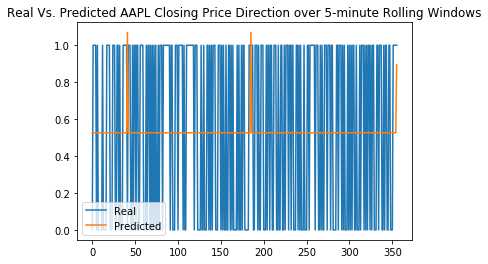

In [1389]:
# Plot the real vs predicted values as a line chart
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pyplot as plt
plt.figure()
positive_sentiments.plot(title=f"Real Vs. Predicted {ticker} Closing Price Direction over 5-minute Rolling Windows")
plt.savefig(f'Images/{ticker}_positive_lstm_5min.png')
plt.show()

<Figure size 432x288 with 0 Axes>

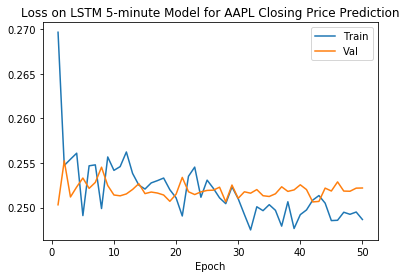

In [1390]:
# Plotting loss
epochs = 50
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["loss"],
        "Val": training_history.history["val_loss"],
    }
)
loss_df.set_index("Epoch", inplace=True)

plt.figure()
loss_df.plot(title=f"Loss on LSTM 5-minute Model for {ticker} Closing Price Prediction")
plt.savefig(f'Images/{ticker}_loss_positive_sentiments_5min.png')
plt.show()

In [1397]:
import h5py

model.save(f'Models/{ticker}_lstm_loss_5min.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

In [1400]:
from keras.models import load_model
import tensorflow as tf
from tensorflow import keras
# returns a compiled model
# identical to the previous one
model = tf.keras.models.load_model(f'Models/{ticker}_lstm_loss_5min.h5')